In [2]:
import numpy as np
from stable_log_one_minus_exp import *
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

%matplotlib notebook

In [3]:
n=1000 #sample size
real=np.random.uniform(0.0,1.0,n) # "real" data
fake=np.random.uniform(1.0,2.0,n) # noisy input for G
w_D=1
w_G=1

### plot objectives

In [ ]:
s=0.25
x_ax = np.arange(-4, 4+s, s)   #Discriminator
y_ax = np.arange(-4,4+s, s)   #Generator
x_ax,y_ax = np.meshgrid(x_ax,y_ax)
z_D=np.zeros((x_ax.shape[0],x_ax.shape[1]))
z_G=np.zeros((x_ax.shape[0],x_ax.shape[1]))


for i in range(x_ax.shape[0]):
    for j in range(x_ax.shape[1]):
        forward_D_real=np.dot(real,w_D)+x_ax[i,j]
        forward_G=np.dot(fake,w_G)+y_ax[i,j]
        forward_D_fake=np.dot(forward_G,w_D)+x_ax[i,j]
        z_D[i,j]=np.sum(-forward_D_real**2)+np.sum(log_one_minus_exp_minus_a(forward_D_fake**2))
        z_G[i,j]=-z_D[i,j]

fig = plt.figure(1)
ax = fig.gca(projection='3d')         # set the 3d axes
ax.plot_surface(x_ax, y_ax, z_D,cmap='viridis', 
                    alpha=0.6)            # transparency of the surface 
#ax.plot_surface(x_ax, y_ax, z_G,cmap='inferno', 
               #     alpha=0.6)  
#cset = ax.contour(x_ax, y_ax, z, zdir='viridis', cmap=cm.coolwarm)
plt.xlabel('Discriminator')
plt.ylabel('Generator')
plt.scatter(1,1,-5000)

### Optimize 

In [43]:
epochs=1
steps_D=1
steps_G=1
iterations=20000
step_size=0.025
sample_size=n

#### Gradient Descent

<IPython.core.display.Javascript object>


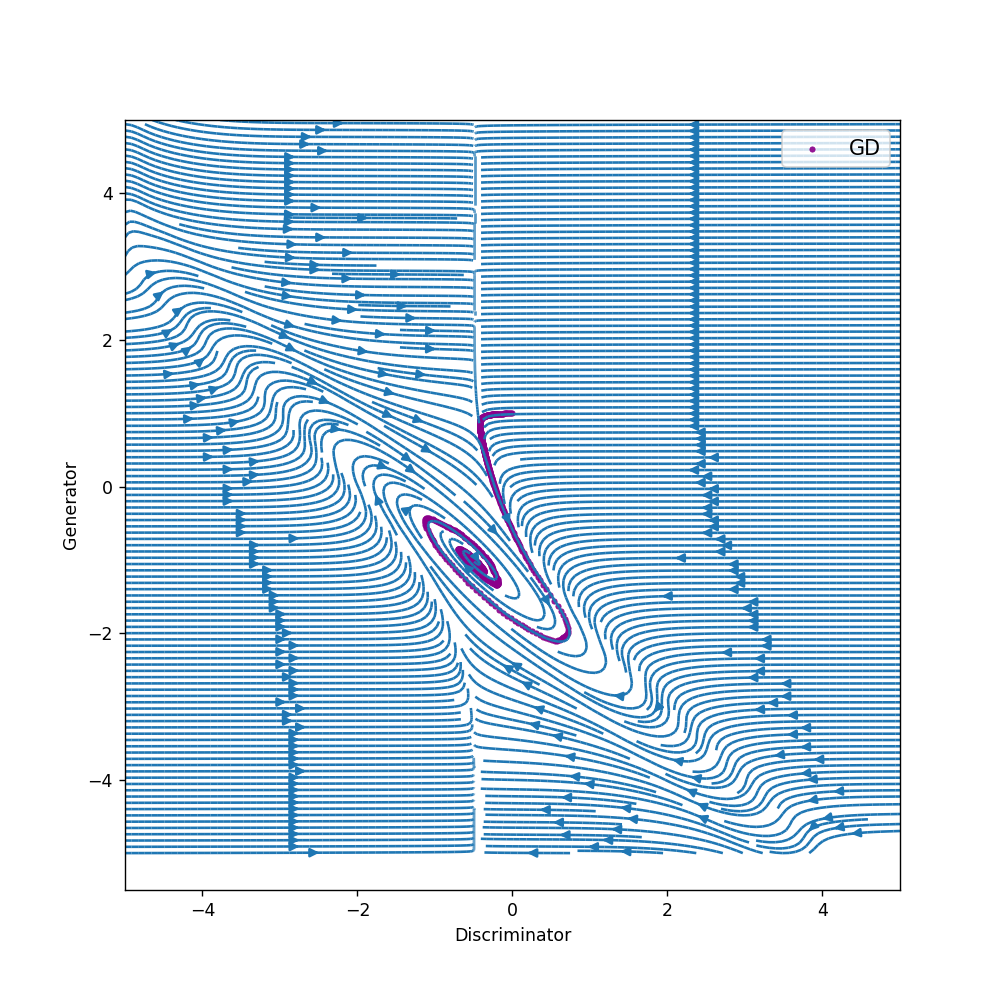

In [41]:
# Run GD (simultaneously)
iterates_D=[]
iterates_G=[]
b_D=0
b_G=1

for k in range(iterations):   
    # forward pass
    forward_D_real=0.001 + 0.998*np.exp(-(np.dot(real,w_D)+b_D)**2)
    forward_G=np.dot(fake_batch,w_G)+b_G
    forward_G[forward_G > 5] = 5
    forward_G[forward_G < -5] = -5 #some thresholding for stability

    forward_D_fake=0.001 + 0.998*np.exp(-(np.dot(forward_G,w_D)+b_D)**2)
    # calculate gradients
    gradient_D=(np.sum(-2*(np.dot(real,w_D)+b_D))+np.sum(2*(np.dot(forward_G,w_D)+b_D)*forward_D_fake/(1-forward_D_fake)))/(2*n)
    gradient_G=+np.sum(2*(np.dot(forward_G,w_D)+b_D)*forward_D_fake/(1-forward_D_fake))/(2*n)
        
    #take step    
    b_G=b_G-step_size*gradient_G
    b_D=b_D+step_size*gradient_D
    iterates_D.append(b_D)
    iterates_G.append(b_G)
    
# Plot iterates
make_plot(iterates_D, iterates_G,20)

<IPython.core.display.Javascript object>


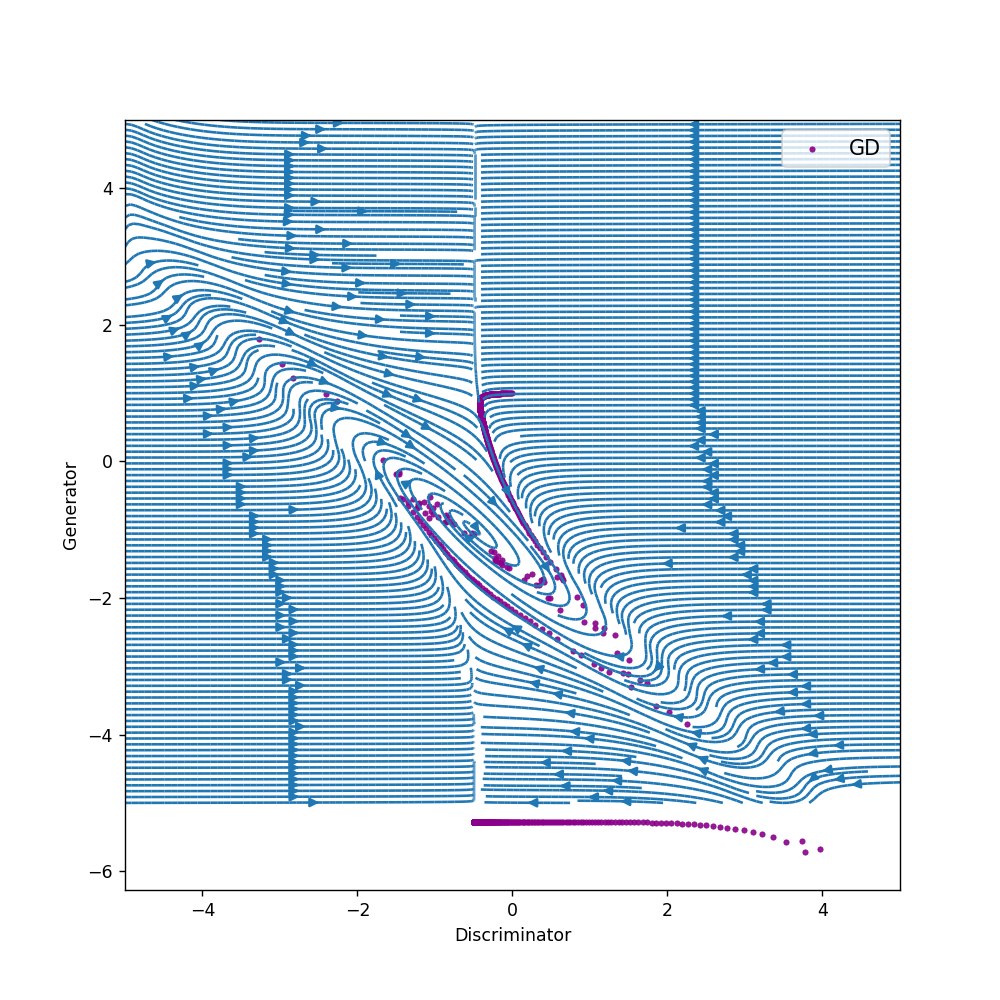

In [44]:
# Run GD (simultaneously)
iterates_D=[]
iterates_G=[]
b_D=0
b_G=1
for k in range(iterations):
    for step in range(steps_D):
        # Compute gradient of D
        idx=np.random.permutation(n)[0:sample_size]
        real_batch=real[idx]
        fake_batch=fake[idx]
        
        
        
        forward_D_real=np.dot(real_batch,w_D)+b_D
        forward_G=np.dot(fake_batch,w_G)+b_G
        forward_D_fake=np.dot(forward_G,w_D)+b_D
        gradient_D=(np.sum(-2*(forward_D_real))+np.sum(2*forward_D_fake/(np.expm1(forward_D_fake**2))))/(2*n)
        
        
    for step in range(steps_G):
        #Compute gradient of G
        idx=np.random.permutation(1000)[0:sample_size]
        fake_batch=fake[idx]
        forward_G=np.dot(fake_batch,w_G)+b_G
        forward_D_fake=np.dot(forward_G,w_D)+b_D
        gradient_G=np.sum(2*forward_D_fake/(np.expm1(forward_D_fake**2)))/(2*n)
        
    #take step    
    b_G=b_G-step_size*gradient_G
    b_D=b_D+step_size*gradient_D
    iterates_D.append(b_D)
    iterates_G.append(b_G)
    
# Plot iterates
make_plot(iterates_D, iterates_G,2)

#### Extra Gradient

<IPython.core.display.Javascript object>


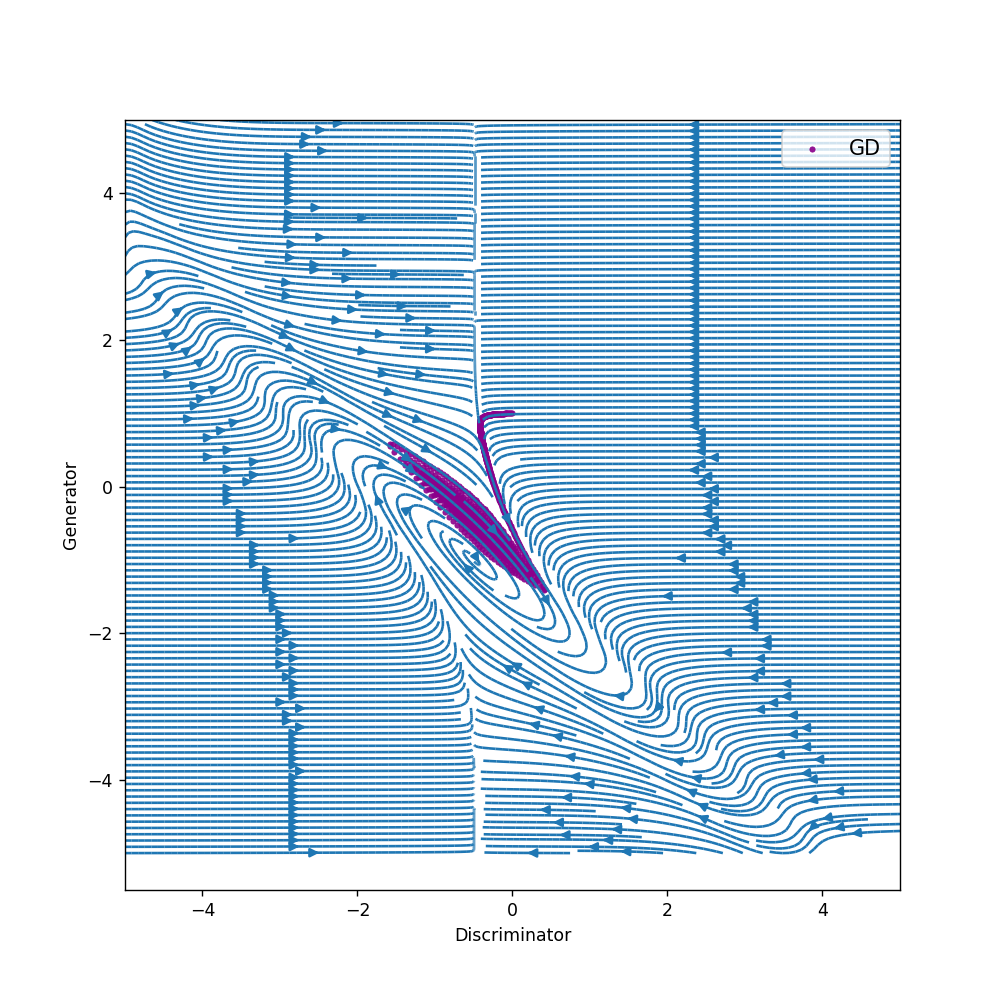

In [45]:
#Run EG
iterates_D=[]
iterates_G=[]
b_D=0
b_G=1
for k in range(iterations): # reshuffling and multiple D steps make no sense here??
    #Sample
    idx=np.random.permutation(1000)[0:sample_size]
    real_batch=real[idx]
    fake_batch=fake[idx]

    #make GD step 
    forward_D_real=0.001 + 0.998*np.exp(-(np.dot(real,w_D)+b_D)**2)
    forward_G=np.dot(fake_batch,w_G)+b_G
    forward_G[forward_G > 5] = 5
    forward_G[forward_G < -5] = -5 #some thresholding for stability

    forward_D_fake=0.001 + 0.998*np.exp(-(np.dot(forward_G,w_D)+b_D)**2)
    # calculate gradients
    gradient_D=(np.sum(-2*(np.dot(real,w_D)+b_D))+np.sum(2*(np.dot(forward_G,w_D)+b_D)*forward_D_fake/(1-forward_D_fake)))/(2*n)
    gradient_G=np.sum(2*(np.dot(forward_G,w_D)+b_D)*forward_D_fake/(1-forward_D_fake))/(2*n)
        

    b_D_extra=b_D+step_size*gradient_D
    b_G_extra=b_G-step_size*gradient_G

    
    #calculate extra gradient
    forward_D_real=0.001 + 0.998*np.exp(-(np.dot(real,w_D)+b_D_extra)**2)
    forward_G=np.dot(fake_batch,w_G)+b_G_extra
    forward_G[forward_G > 5] = 5
    forward_G[forward_G < -5] = -5 #some thresholding for stability

    forward_D_fake=0.001 + 0.998*np.exp(-(np.dot(forward_G,w_D)+b_D_extra)**2)
    # calculate gradients
    gradient_D_extra=(np.sum(-2*(np.dot(real,w_D)+b_D))+np.sum(2*(np.dot(forward_G,w_D)+b_D)*forward_D_fake/(1-forward_D_fake)))/(2*n)
    gradient_G_extra=np.sum(2*(np.dot(forward_G,w_D)+b_D)*forward_D_fake/(1-forward_D_fake))/(2*n)

    #apply extra gradient to original iterate
    b_D=b_D+step_size*gradient_D_extra
    b_G=b_G-step_size*gradient_G_extra                  

    iterates_D.append(b_D)
    iterates_G.append(b_G)
    
# Plot iterates
make_plot(iterates_D, iterates_G,4)

#### Run Newton

In [ ]:
# Run Newton
iterates_D=[]
iterates_G=[]
b_D=1
b_G=-2
for k in range(iterations):
    for step in range(steps_d):
        #Compute gradient of D
        idx=np.random.permutation(n)[0:sample_size]
        real_batch=real[idx]
        fake_batch=fake[idx]
    
        forward_D_real=np.dot(real_batch,w_D)+b_D
        forward_G=np.dot(fake_batch,w_G)+b_G
        forward_D_fake=np.dot(forward_G,w_D)+b_D
        gradient_D=(np.sum(-2*(forward_D_real))+np.sum(2*forward_D_fake/(np.expm1(forward_D_fake**2))))/(2*n)
        
    
        
    for step in range(steps_g):
        #Compute gradient of G
        idx=np.random.permutation(1000)[0:sample_size]
        fake_batch=fake[idx]
        forward_G=np.dot(fake_batch,w_G)+b_G
        forward_D_fake=np.dot(forward_G,w_D)+b_D
        gradient_G=-np.sum(2*forward_D_fake/(np.expm1(forward_D_fake**2)))/(2*n)
    
    #Compute and invert Hessian
    H=np.zeros((2,2))
    v=np.sum(np.expm1(forward_D_fake**2))
    _uv=np.sum(np.exp(forward_D_fake**2)*(2-4*forward_D_fake**2)-2)/v**2
    H[0,0]=-2+_uv
    H[0,1]=+_uv
    H[1,0]=-_uv
    H[1,1]=-_uv
    H_inv=np.linalg.inv(H/(2*n))
    #take steps
    print('iterate', b_D,b_G)
    print('grads',gradient_D,gradient_G)
    print('fdf' ,forward_D_fake**2)
    print (H_inv)
    
    b_D=b_D+(H_inv[0,0]*gradient_D+H_inv[0,1]*gradient_G)
    b_G=b_G+(H_inv[1,0]*gradient_D+H_inv[1,1]*gradient_G)

    iterates_D.append(b_D)
    iterates_G.append(b_G)
    
# Plot iterates
make_plot(iterates_D, iterates_G,5)

#### Plot gradient norms

<IPython.core.display.Javascript object>


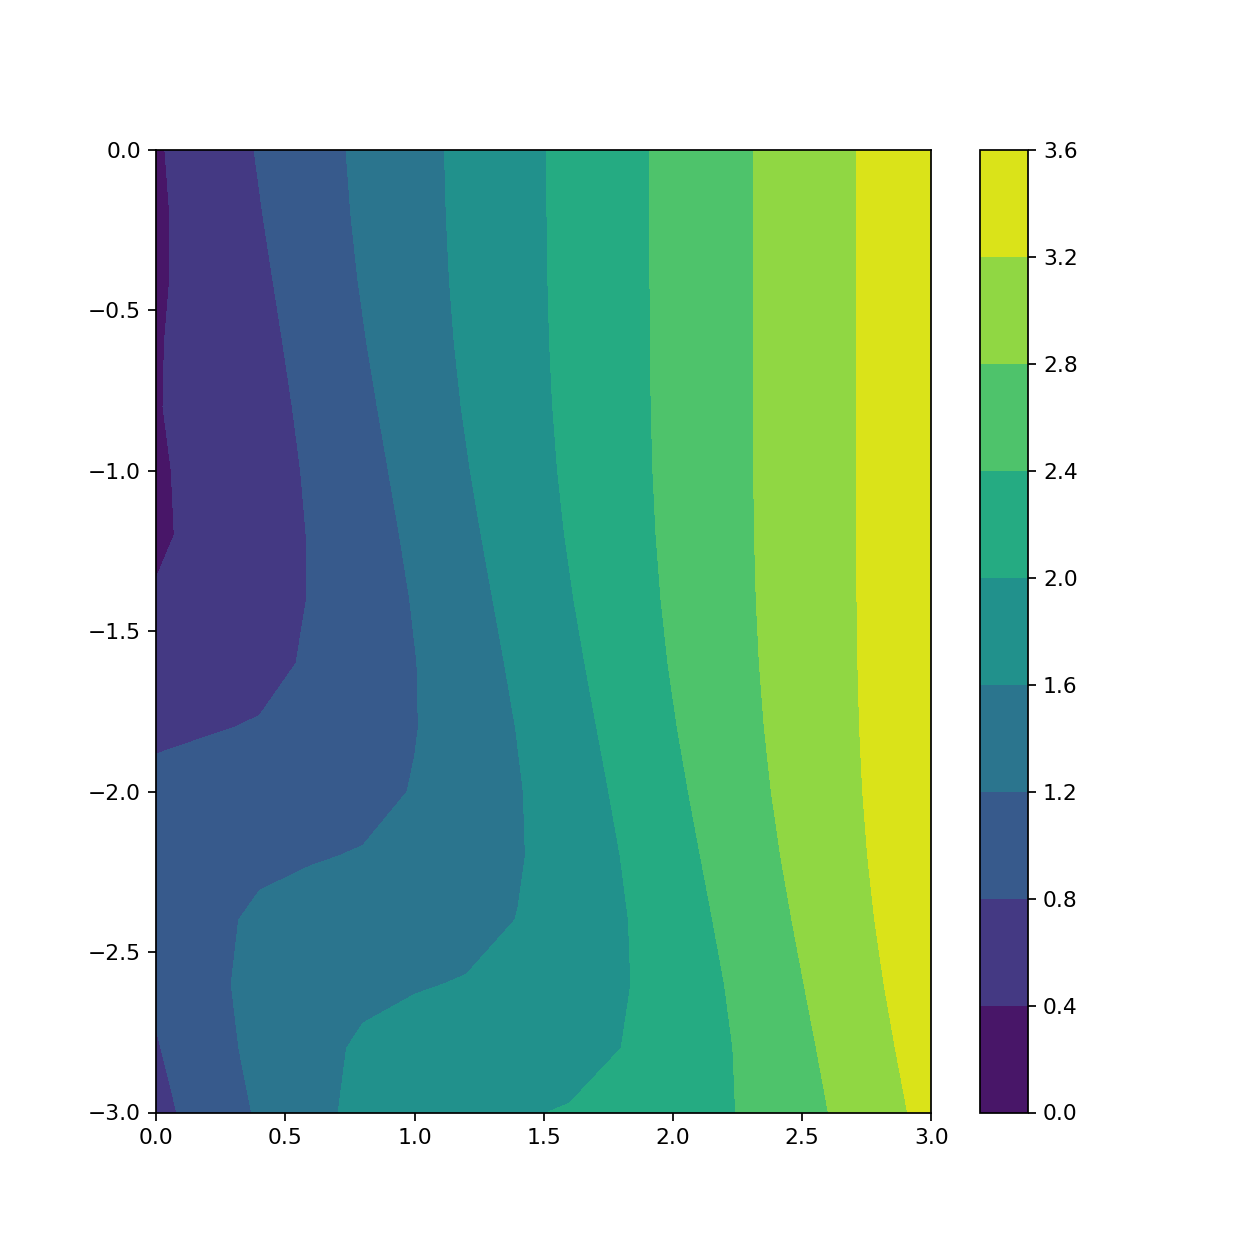

In [33]:
fig=plt.figure(10)
s=0.2
x_ax = np.arange(0,3+s, s)   #Discriminator
y_ax = np.arange(-3,0+s, s)   #Generator
x_ax,y_ax = np.meshgrid(x_ax,y_ax)
gradient_D=np.zeros((x_ax.shape[0],x_ax.shape[1]))
gradient_G=np.zeros((y_ax.shape[0],y_ax.shape[1]))

for i in range(x_ax.shape[0]):
    for j in range(x_ax.shape[1]):
        if False:
            forward_D_real=np.dot(real,w_D)+x_ax[i,j]
            forward_G=np.dot(fake,w_G)+y_ax[i,j]
            forward_D_fake=np.dot(forward_G,w_D)+x_ax[i,j]

            gradient_D[i,j]=(np.sum(-2*(forward_D_real))+np.sum(2*forward_D_fake/(np.expm1(forward_D_fake**2))))
            gradient_G[i,j]=np.sum(2*forward_D_fake/(np.expm1(forward_D_fake**2)))
        else:
            forward_D_real=0.001 + 0.998*np.exp(-(np.dot(real,w_D)+x_ax[i,j])**2)
            forward_G=np.dot(fake_batch,w_G)+y_ax[i,j]
            forward_G[forward_G > 5] = 5
            forward_G[forward_G < -5] = -5 #some thresholding for stability

            forward_D_fake=0.001 + 0.998*np.exp(-(np.dot(forward_G,w_D)+x_ax[i,j])**2)
            # calculate gradients
            gradient_D[i,j]=(np.sum(-2*(np.dot(real,w_D)+x_ax[i,j]))+np.sum(2*forward_D_fake*(np.dot(forward_G,w_D)+x_ax[i,j])))/(2*n)
            gradient_G[i,j]=+np.sum(2*forward_D_fake*(np.dot(forward_G,w_D)+x_ax[i,j]))/(2*n)


z = np.array(np.sqrt(np.array(gradient_D)**2+np.array(gradient_G)**2))
z = z.reshape((len(x_ax), len(y_ax)))
plt.contourf(x_ax,y_ax,z)
plt.colorbar()
plt.gcf().set_size_inches((8,8))
plt.show()



In [36]:
def make_plot(d,g,fig_number):
    s=0.2
    x_ax = np.arange(-5,5+s, s)   #Discriminator
    y_ax = np.arange(-5,5+s, s)   #Generator
    x_ax,y_ax = np.meshgrid(x_ax,y_ax)
    gradient_D=np.zeros((x_ax.shape[0],x_ax.shape[1]))
    gradient_G=np.zeros((y_ax.shape[0],y_ax.shape[1]))

    for i in range(x_ax.shape[0]):
        for j in range(x_ax.shape[1]):
            if False:
                forward_D_real=np.dot(real,w_D)+x_ax[i,j]
                forward_G=np.dot(fake,w_G)+y_ax[i,j]
                forward_D_fake=np.dot(forward_G,w_D)+x_ax[i,j]

                gradient_D[i,j]=(np.sum(-2*(forward_D_real))+np.sum(2*forward_D_fake/(np.expm1(forward_D_fake**2))))
                gradient_G[i,j]=np.sum(2*forward_D_fake/(np.expm1(forward_D_fake**2)))
            else:
                forward_D_real=0.001 + 0.998*np.exp(-(np.dot(real,w_D)+x_ax[i,j])**2)
                forward_G=np.dot(fake_batch,w_G)+y_ax[i,j]
                forward_G[forward_G > 5] = 5
                forward_G[forward_G < -5] = -5 #some thresholding for stability

                forward_D_fake=0.001 + 0.998*np.exp(-(np.dot(forward_G,w_D)+x_ax[i,j])**2)
                # calculate gradients
                gradient_D[i,j]=(np.sum(-2*(np.dot(real,w_D)+x_ax[i,j]))+np.sum(2*(np.dot(forward_G,w_D)+x_ax[i,j])*forward_D_fake/(1-forward_D_fake)))/(2*n)
                gradient_G[i,j]=++np.sum(2*(np.dot(forward_G,w_D)+x_ax[i,j])*forward_D_fake/(1-forward_D_fake))/(2*n)


    fig = plt.figure(fig_number)

    plt.streamplot(x_ax,y_ax,gradient_D,-gradient_G, density=4)

    plt.gcf().set_size_inches((8,8))
    plt.show()
    plt.xlabel('Discriminator')
    plt.ylabel('Generator')

    plt.scatter(d,g,marker='.',c='darkmagenta',linewidth='0.5',alpha=0.9, label='GD')
    plt.legend(fontsize=12)
    
